In [40]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, precision_recall_curve, roc_curve

# Load yelp review dataset

In [2]:
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'yelp_polarity_reviews', split=['train', 'test[:50]', 'test[50:]'],
  as_supervised=True, with_info=True, data_dir='data'
)

# Simple EDA
- Word Distribution
- Class Distribution

In [3]:
train_df = tfds.as_dataframe(train_ds, ds_info)

In [4]:
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.decode('utf-8').split(' ')))

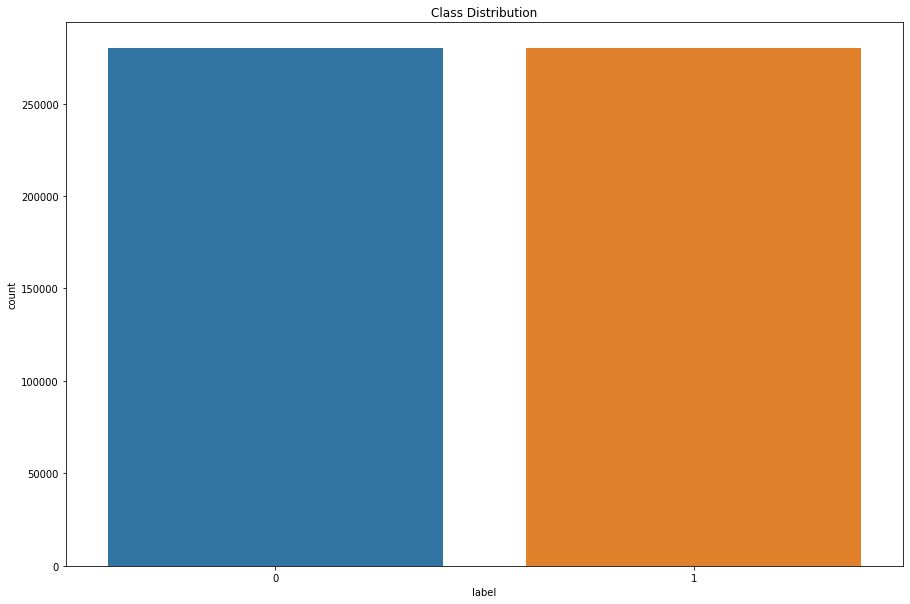

In [5]:
plt.figure(figsize=(15, 10))
plt.title('Class Distribution')
sns.countplot(data=train_df, x='label')

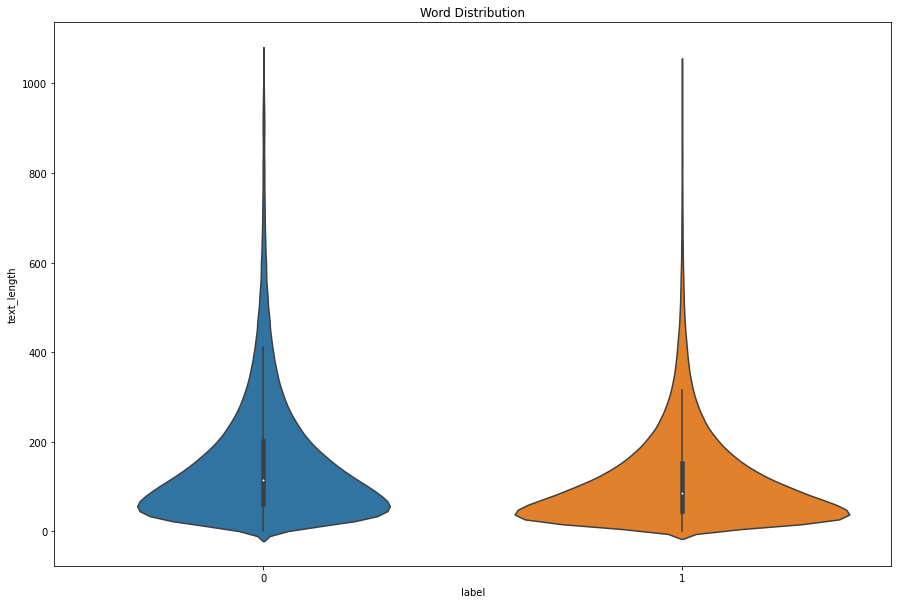

In [6]:
plt.figure(figsize=(15, 10))
plt.title('Word Distribution')
sns.violinplot(data=train_df, y='text_length', x='label')

In [7]:
sample_df = train_df.sample(10)
sample_df['text'].tolist() # Show some samples

[b"Love this place!  I've been going here for a few years.  The staff is friendly, the prices are great and they do an excellent job.  I highly recommend the VIP pedicure.",
 b"Of all the resorts in Vegas, Mandalay is up there for me. Primarily because I think you get pretty decent bang for the buck. Rooms are spacious, relatively premium decor (though a little older) in a decent resort with decent restaurants (MGM is my go-to place for food). Their pool is pretty nice and during the evenings they often have concerts and other fun events.\\n\\nThe downsides are obvious - Mandalay is farther down the strip but they do have the tram that helps. They opened theHotel but I feel like the main hotel is going to need a freshening especially as they're bunched in with Excalibur and the Luxor which are decidedly downmarket.\\n\\nOtherwise, I like everything else including the conference halls (which is why I'm there 99% of the time).",
 b'Absolutely not the best Italian food I have ever had. Be

# Map data

In [8]:
@tf.function
def one_hot_label(text, label):
  return text, tf.one_hot(label, 2)
  
train_ds = train_ds.shuffle(len(train_ds)).map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(one_hot_label, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)

# Build Model
- Lets use the keras hublayer to build a model

In [9]:
use = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4', trainable=True,
    input_shape=[], dtype=tf.string,
)

In [10]:
model = tf.keras.Sequential([
    use,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 256,929,666
Trainable params: 256,929,666
Non-trainable params: 0
_________________________________________________________________


# Train and plot history

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [13]:
history = model.fit(train_ds, epochs=2, validation_data=valid_ds)

Epoch 1/2
8750/8750 [==============================] - 1605s 180ms/step - loss: 0.1617 - accuracy: 0.9382 - val_loss: 0.1950 - val_accuracy: 0.9200
Epoch 2/2
8750/8750 [==============================] - 1591s 179ms/step - loss: 0.0771 - accuracy: 0.9731 - val_loss: 0.2506 - val_accuracy: 0.9200


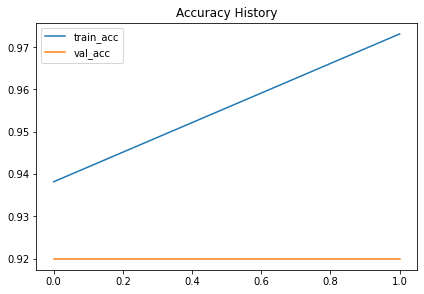

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(221)
plt.title('Loss History')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(222)
plt.title('Accuracy History')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

In [15]:
model.evaluate(test_ds)

593/593 [==============================] - 30s 51ms/step - loss: 0.1229 - accuracy: 0.9570


[0.12286333739757538, 0.956969678401947]

# Evaluate the model

In [22]:
test_data = tfds.as_numpy(test_ds)

In [30]:
y_true = []
for _, label in test_data:
  y_true.append(label)

In [31]:
y_true = np.concatenate(y_true).argmax(axis=1)

In [26]:
y_pred = model.predict(test_ds).argmax(axis=1)

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     18978
           1       0.96      0.96      0.96     18972

    accuracy                           0.96     37950
   macro avg       0.96      0.96      0.96     37950
weighted avg       0.96      0.96      0.96     37950



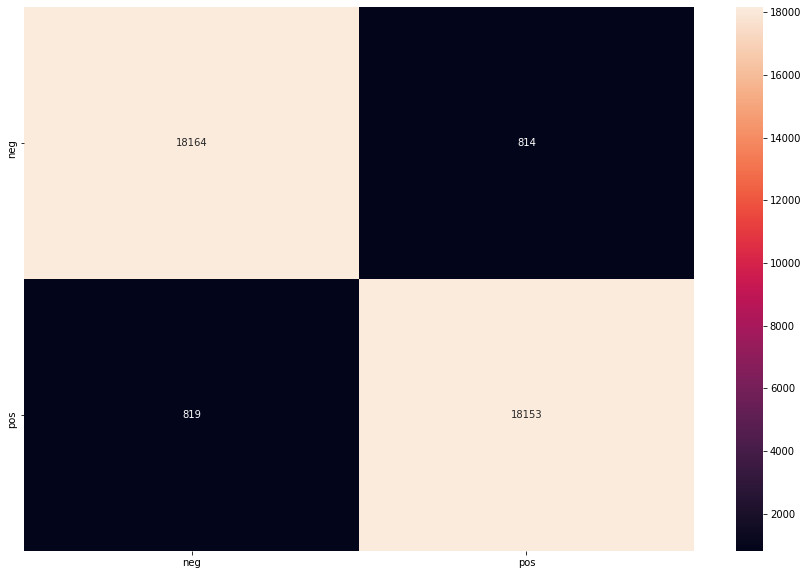

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), fmt='3', annot=True, xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])

In [36]:
print('MCC: {}'.format(round(matthews_corrcoef(y_true, y_pred) * 100, 2)))

MCC: 91.39


In [39]:
prec, rec, tre = precision_recall_curve(y_true, y_pred)

(0.0, 1.0)

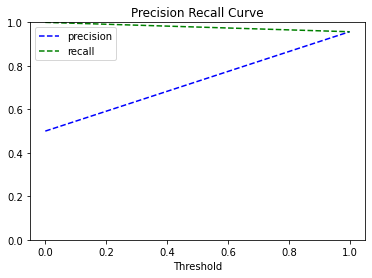

In [42]:
plt.title('Precision Recall Curve')
plt.plot(tre, prec[:-1], 'b--', label='precision')
plt.plot(tre, rec[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])

In [43]:
fpr, tpr, thresh= roc_curve(y_true, y_pred)

Text(0, 0.5, 'False Negative Rate')

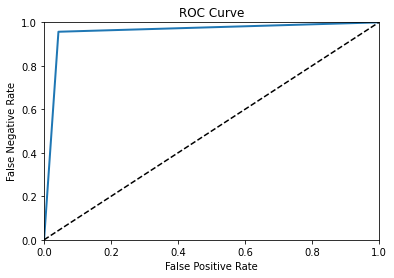

In [45]:
plt.title('ROC Curve')
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.axis([0,1,0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")